In [ ]:
import dask.dataframe as dd
import spacy
from tqdm import tqdm
import dask
import timeit

from dask.diagnostics import progress
from dask.callbacks import Callback
from dask.distributed import Client, LocalCluster
from distributed.worker import logger

import re
import logging
import humanize
import psutil
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from dask.diagnostics.progress import ProgressBar
import dask.bag as db

print("Total CPU cores: ", psutil.cpu_count())
mem = psutil.virtual_memory()
print("Total memory: ", mem.total / (1024.0 ** 3), "GB")

dask_cpus = psutil.cpu_count()
dask_memory = (mem.total / (1024.0 ** 3)) * 0.9

# Create dask client
client = Client(LocalCluster(n_workers=dask_cpus, threads_per_worker=1, memory_limit=f'{dask_memory}GB'))
print(f'Dask Dashboard: {client.dashboard_link}')

# disable dask warnings
logging.getLogger('distributed.worker').setLevel(logging.ERROR)

# show dask progress bar
pbar = ProgressBar()
pbar.register()


# PERFORMANCE TESTS

This is a test to check with methods is faster in removing puctuations and digits

In [9]:
import random
import string
import timeit
import re

def generate_random_text(length):
    text = ''.join(random.choice(string.ascii_letters + string.punctuation + string.digits) for _ in range(length))
    return text

# Generate random text of length 100
random_text = generate_random_text(100)
print('Text to Clean:', random_text)

# test performance of regex to remove punctuation and digits using timeit
print('Regex Performance:', timeit.timeit(lambda: re.sub(r'[^\w\s]|(\d+)', '', random_text), number=10000))

# test performance of spacy to remove punctuation and digits using timeit
print('Spacy Performance:', timeit.timeit(lambda: [token.text for token in nlp(random_text) if not token.is_punct and not token.is_digit], number=10000))

# test performance of string.translate to remove punctuation and digits using timeit
print('Translate Performance:', timeit.timeit(lambda: random_text.translate(str.maketrans('', '', string.punctuation + string.digits)), number=10000))


qJ/H#^i$^rC6^gNrF,|W$ZdZn_Lc=c<5.nk9[+j${`X~[.B2bp9YkJARRxHuNOlBGC@@3N.w&'w:8W%4ssY9BY>-aOh\4#AzNY!j
Regex Performance 0.16247754500000156
Spacy Performance 62.25264147499911
Translate Performance 0.06302595400120481


This is a test to check what is fastest method to remove stop words

In [12]:
# List all stop words from spacy
stop_words = nlp.Defaults.stop_words

import random
import string
import timeit
import re

# Generate random text of length 100
random_text = "Text pre-processing is the process of preparing text data so that \
machines can use the same to perform tasks like analysis, predictions, etc. \
There are many different steps in text pre-processing but in this article, we will \
only get familiar with stop words, why do we remove them, and the different \
libraries that can be used to remove them."

print('Text to Clean:', random_text)

# Test performance of spacy to remove stop words using timeit
print('Spacy Performance:', timeit.timeit(lambda: [token.text for token in nlp(random_text) if not token.is_stop], number=1000))

# Test performance of regex to remove stop words using timeit
print('Regex Performance:', timeit.timeit(lambda: re.sub(r'\b(' + r'|'.join(stop_words) + r')\b', '', random_text), number=1000))

# Test performance of string.translate to remove stop words using timeit
print('Translate Performance:', timeit.timeit(lambda: random_text.translate(str.maketrans('', '', ' '.join(stop_words))), number=1000))

# Test performance of string.replace to remove stop words using timeit
print('Replace Performance:', timeit.timeit(lambda: random_text.replace(' '.join(stop_words), ''), number=1000))

# Test performance of list comprehension to remove stop words using timeit
print('List Comprehension Performance:', timeit.timeit(lambda: ' '.join([word for word in random_text.split() if word not in stop_words]), number=1000))


Text to Clean: Text pre-processing is the process of preparing text data so that machines can use the same to perform tasks like analysis, predictions, etc. There are many different steps in text pre-processing but in this article, we will only get familiar with stop words, why do we remove them, and the different libraries that can be used to remove them.
Spacy Performance: 13.791717508000147
Regex Performance: 0.15690902699861908
Translate Performance: 0.06283395100035705
Replace Performance: 0.014842661999864504
List Comprehension Performance: 0.016670594999595778


This is a test to check fastest way to lemmatize text

In [16]:
import timeit
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

# Generate random text of length 100
random_text = "Text pre-processing is the process of preparing text data so that \
machines can use the same to perform tasks like analysis, predictions, etc. \
There are many different steps in text pre-processing but in this article, we will \
only get familiar with stop words, why do we remove them, and the different \
libraries that can be used to remove them."

# lemmatize text using nltk
def lemmatize_text(text):
    lemmatized_text = []
    for word, tag in pos_tag(text.split()):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_text.append(lemmatizer.lemmatize(word, pos))
    ' '.join(lemmatized_text)

print('Text to Clean:', random_text)

# Test performance of spacy to lemmatize text using timeit
print('Spacy Performance:', timeit.timeit(lambda: [token.lemma_ for token in nlp(random_text)], number=1000))

# Test performance of nltk to lemmatize text using timeit
print('NLTK Performance:', timeit.timeit(lambda: lemmatize_text(random_text), number=1000))

Text to Clean: Text pre-processing is the process of preparing text data so that machines can use the same to perform tasks like analysis, predictions, etc. There are many different steps in text pre-processing but in this article, we will only get familiar with stop words, why do we remove them, and the different libraries that can be used to remove them.
Spacy Performance: 15.684729975000664
NLTK Performance: 4.851827831000264


# DATA PROCESSING

In [35]:
def read_csv(file_name: str, columns_list: list):
    df = dd.read_csv(file_name)
    df.columns = columns_list
    return df

def optimize_dataframe_for_text(df, text_column: str):
    df[text_column] = df[text_column].astype("string[pyarrow]")
    # list all columns except text column
    columns = [col for col in df.columns if col != text_column]
    # drop all columns except text column
    df = df.drop(columns, axis=1)
    return df

# print all partitions in dataframe and there size
def print_partitions(df):
    print(f'Total Partitions: {df.npartitions}')
    print(f'Total Data Size: {humanize.naturalsize(df.memory_usage(deep=True).sum().compute())}')
    # print length of each partition
    print(f'Total Records: {humanize.intword(df.shape[0].compute())}')

# remove all short words from text  (length < 3)
def remove_short_words(text):    
    return ' '.join([word for word in text.split() if len(word) > 2])

# remove all non-ascii characters
def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

# remove all punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

# remove all digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

LEMMATIZER = WordNetLemmatizer()
def lemmatize_text(text, lemmatizer=LEMMATIZER):
    lemmatized_text = []
    for word, tag in pos_tag(text.split()):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_text.append(lemmatizer.lemmatize(word, pos))
    return ' '.join(lemmatized_text)

# Remove puctuations and digits
def remove_punctuation_and_digits(text):
    return text.translate(str.maketrans('', '', string.punctuation + string.digits))

# list all stop words from nltk
STOP_WORDS = stopwords.words('english')
# remove all stop words from text
def remove_stop_words(text, stop_words=STOP_WORDS):    
    return ' '.join([word for word in text.split() if word not in stop_words])

In [38]:
def clean_text(file_name, columns, text_column, output_column, output_file_name):
    # load data
    df = read_csv(file_name=file_name, columns_list=columns)
    # df = df.sample(frac=0.05) # Use for testing
    df = optimize_dataframe_for_text(df, text_column=text_column)
    # print partition details
    print_partitions(df)

    # clean text
    df['cleaned_desc'] = (df[text_column].astype("string[pyarrow]").str.lower()
                          .map(remove_short_words, meta=(text_column, 'string[pyarrow]'), na_action='ignore')
                          .map(remove_non_ascii, meta=(text_column, 'string[pyarrow]'), na_action='ignore')
                          .map(remove_punctuation_and_digits, meta=(text_column, 'string[pyarrow]'), na_action='ignore')
                          .map(remove_stop_words, meta=(text_column, 'string[pyarrow]'), na_action='ignore')
                          .map(lemmatize_text, meta=(text_column, 'string[pyarrow]'), na_action='ignore')

    # write to parquet
    df.to_parquet(f'{output_file_name}.parquet', engine='pyarrow',
                           compression='snappy', write_index=False)
    # df.compute()


if __name__ == '__main__':
    inputs =    {
                # 'po': {'file_name': '/Users/roopakkprajapat/Downloads/po.csv',
                #     'columns': ['client', 'desc', '1', '2', '3', '4'],
                #     'text_column': 'desc',
                #     'output_column': 'cleaned_desc',
                #     'output_file_name': 'po'},
                'invoice': {'file_name': '/Users/roopakkprajapat/Downloads/invoice.csv',
                            'columns': ['Client', 'Description', 'CaseFlag', 'CaseRowID', 'TestsFailed',
                                        'OverallRiskScore', 'GLDesc', 'isTagged', 'FalsePositive'],
                            'text_column': 'Description',
                            'output_column': 'cleaned_desc',
                            'output_file_name': 'invoice'}
                }

    for key in inputs:
        # print dividing line
        print('-' * 100)
        print('Processing:', key)
        print('-' * 100)
        print('Total Runtime:', humanize.naturaldelta(timeit.timeit(lambda: clean_text(**inputs[key]), number=1)))
        print('---- Running Validation ----')
        
        df = dd.read_parquet(f"{inputs.get(key).get('output_file_name')}.parquet", engine='pyarrow')
        print(f'Total records: {humanize.intword(len(df))}')
        print(df.isnull().sum().compute())


----------------------------------------------------------------------------------------------------
Processing: invoice
----------------------------------------------------------------------------------------------------
Total Partitions: 6
Total Data Size: 72.7 MB
Total Records: 5.5 million
Total Runtime: 5 minutes
---- Running Validation ----
Total records: 5.5 million
Description     2157311
cleaned_desc    2157311
dtype: int64


# TOP N-GRAMS FROM TEXT

In [ ]:
from nltk.util import ngrams
import time


def ngrams_generator(text, n):
    if text is None:
        return None
    tokens = str(text).split()
    all_ngrams = []
    for n in range(1, n+1):
        n_grams = ngrams(tokens, n)
        all_ngrams += list([' '.join(grams) for grams in n_grams])
    return all_ngrams

def word_freq_generator(df, text_column, output_file_name):
    # create n grams from text in a dask column through for loop and add to dask bag
    bag = df[text_column].to_bag()

    # Convert text in each row to list of ngrams of shape (1, 3)
    # bag = bag.map_partitions(lambda chunk: ngrams_generator(text, 3) if text is not None else None)
    bag = bag.map_partitions(lambda text: [ngrams_generator(t, 3) for t in text])
    # drop missing values and None
    bag = bag.filter(lambda x: x is not None and len(x) > 0)
    # flatten list of lists
    bag = bag.flatten()
    
    return bag


if __name__ == '__main__':
    start_time = time.perf_counter()
    inputs = ['po', 'invoice']

    # create new empty dask bag
    bag = db.from_sequence([])
    
    for key in inputs:
        df = dd.read_parquet(f'{key}.parquet', engine='pyarrow')
        # print dividing line
        print('Processing:', key)
        result = word_freq_generator(df, 'cleaned_desc', key)
        bag = db.concat([bag, result])
        
    bag = bag.frequencies(sort=True)

    bag.to_dataframe().to_csv('word_frequencies.txt', index=False, header=False, single_file=True)
    print(f'Word frequencies saved to word_frequencies.txt')
    print(f'Total time taken: {humanize.naturaldelta(time.perf_counter() - start_time)}')


# Create wordcloud

2023-01-24 09:59:06,352 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 09:59:06,812 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 09:59:07,427 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 09:59:08,131 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 09:59:08,873 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 09:59:09,844 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-24 09:59:13,259 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-01-24 09:59:14,202 - distributed.utils_perf - WARNING - full garbage collections took

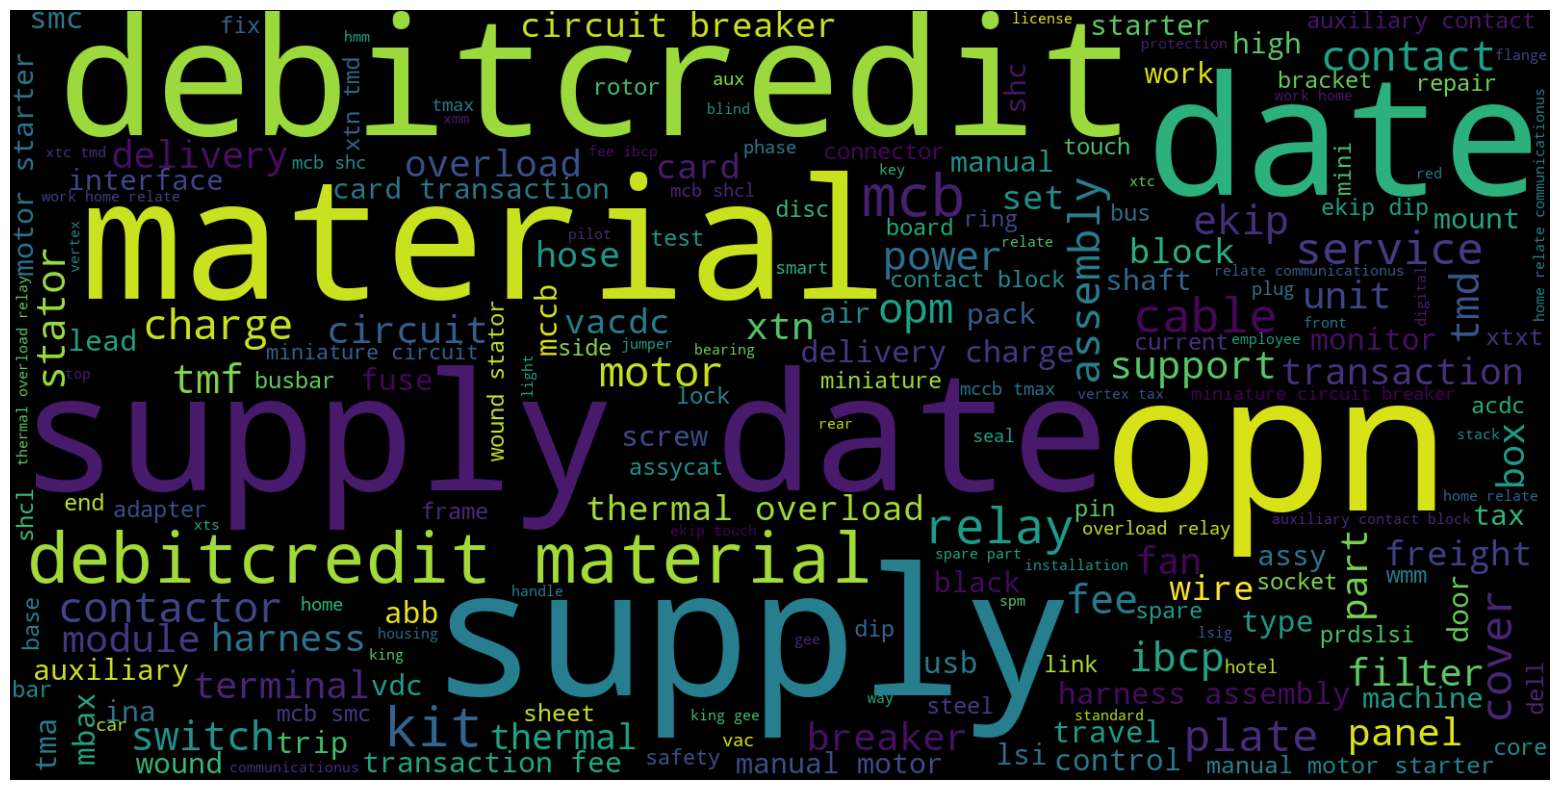

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# load text file in dask bag
bag = db.read_text('word_frequencies.txt', blocksize=25e6, encoding='utf-8')

# split each row of dask bag item on comma using map_partitions
bag = bag.map_partitions(lambda x: [item.split(',') for item in x])

# convert to dataframe
df = bag.to_dataframe(columns=['word', 'count'])
# convert count to int
df['count'] = df['count'].astype(int)

# take first 500 rows
df = df.head(500)

# convert dask series to dictionary
items_dict = df.set_index('word')['count'].to_dict()

# generate word cloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate_from_frequencies(items_dict)

# show word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Word corrections

In [ ]:
# TODO: Use spell checker to correct spelling. Current nltk corpus is not good enough


# use nltk to correct spelling
from nltk.corpus import words
from nltk.metrics import edit_distance
from collections import defaultdict
import dask.bag as db
from tqdm import tqdm
import textdistance
import json

# load text file in dask bag
bag = db.read_text('word_frequencies.txt', blocksize=25e6, encoding='utf-8')

# split each row of dask bag item on comma using map_partitions
bag = bag.map_partitions(lambda x: [item.split(',') for item in x])

# convert to dataframe
df = bag.to_dataframe(columns=['word', 'count'])

# convert count to int
df['count'] = df['count'].astype(int)

# take first 500 rows   
df = df.head(500)

# dump all words in a list from data frame column
items_dict = set(df['word'].to_list())

# load all words from nltk corpus
word_list = set(words.words())

# create a dictionary to store corrected words
corrected_words = {}

def get_correction(word):
    result = None
    # check if word is already in corrected_words
    if word in corrected_words:
        return result
    # check if word is in nltk corpus
    if word not in word_list:
        # if word is not in word_list, find closest word in word_list
        closest_word = min(word_list, key=lambda w: textdistance.levenshtein.distance(word, w))
        result = closest_word
    return result


# iterate through each word in dictionary
for text in tqdm(items_dict):
    # split string by whitespace to check if its a single word
    total_words = len(text.split(' '))
    if total_words > 1:
        for word in tqdm(text.split(' '), leave=False):
            # get closest word in word_list
            closest_word = get_correction(word)
            corrected_words[word] = (closest_word)
    else:
        closest_word = get_correction(text)
        corrected_words[text] = (closest_word)

# filter dictionary to remove None values
corrected_words = {k: v for k, v in corrected_words.items() if v is not None}

print(json.dumps(corrected_words, indent=4))

